# Import Package

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# import PyTorch's common packages
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# checking for CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [3]:
# import data
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])

# added features
df["quarter"] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


# Plot Data

C:\Users\HP\miniconda3\envs\jcopdl\lib\site-packages\pandas\plotting\_matplotlib\core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


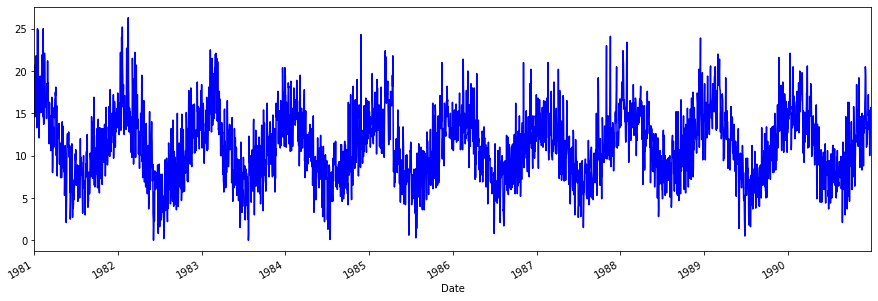

In [4]:
# plot data
df.Temp.plot(figsize=(15, 5), colors="b")

# Dataset Splitting

In [5]:
# split data time series
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Dataset & Dataloader

In [7]:
# import packages
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [8]:
# Pipeline
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 5)
Note: last 7 data excluded

(N, S, F): (52, 14, 5)
Note: last 1 data excluded



# RNN Architecture using GRU

In [9]:
# RNN architecture with GRU
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

# Config

In [11]:
# set tuning config
config = set_config({
    "input_size":train_set.n_feature,
    "output_size":1,
    "hidden_size":64,
    "num_layers":2,
    "dropout":0
})

# Training Preparation -> MCOC

In [12]:
# Model
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)

# Criterion
criterion = nn.MSELoss(reduction="mean")

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Callback
callback = Callback(model, config, outdir="model/multivar")

# Training

In [13]:
# loop function
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 133.9304 | Test_cost  = 124.6253 | 




Epoch     2
Train_cost  = 106.7759 | Test_cost  = 98.5178 | 




Epoch     3
Train_cost  = 83.5861 | Test_cost  = 78.1505 | 




Epoch     4
Train_cost  = 66.6842 | Test_cost  = 64.7370 | 




Epoch     5
Train_cost  = 55.8719 | Test_cost  = 55.8965 | 




Epoch     6
Train_cost  = 48.4682 | Test_cost  = 49.2297 | 




Epoch     7
Train_cost  = 42.7066 | Test_cost  = 43.7397 | 




Epoch     8
Train_cost  = 37.9226 | Test_cost  = 39.0871 | 




Epoch     9
Train_cost  = 33.8935 | Test_cost  = 35.1472 | 




Epoch    10
Train_cost  = 30.5137 | Test_cost  = 31.8246 | 




Epoch    11
Train_cost  = 27.6940 | Test_cost  = 29.0366 | 




Epoch    12
Train_cost  = 25.3574 | Test_cost  = 26.7112 | 




Epoch    13
Train_cost  = 23.4364 | Test_cost  = 24.7849 | 




Epoch    14
Train_cost  = 21.8708 | Test_cost  = 23.2004 | 




Epoch    15
Train_cost  = 20.6068 | Test_cost  = 21.9067 | 




Epoch    16
Train_cost  = 19.5961 | Test_cost  = 20.8581 | 




Epoch    17
Train_cost  = 18.7960 | Test_cost  = 20.0140 | 




Epoch    18
Train_cost  = 18.1689 | Test_cost  = 19.3389 | 




Epoch    19
Train_cost  = 17.6820 | Test_cost  = 18.8020 | 




Epoch    20
Train_cost  = 17.3077 | Test_cost  = 18.3772 | 


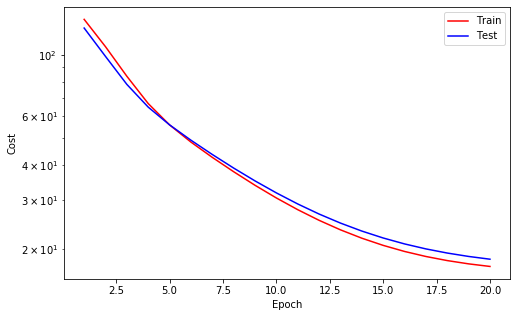



Epoch    21
Train_cost  = 17.0222 | Test_cost  = 18.0423 | 




Epoch    22
Train_cost  = 16.8063 | Test_cost  = 17.7791 | 




Epoch    23
Train_cost  = 16.6441 | Test_cost  = 17.5725 | 




Epoch    24
Train_cost  = 16.5229 | Test_cost  = 17.4105 | 




Epoch    25
Train_cost  = 16.4324 | Test_cost  = 17.2833 | 




Epoch    26
Train_cost  = 16.3650 | Test_cost  = 17.1832 | 




Epoch    27
Train_cost  = 16.3145 | Test_cost  = 17.1041 | 




Epoch    28
Train_cost  = 16.2762 | Test_cost  = 17.0412 | 




Epoch    29
Train_cost  = 16.2466 | Test_cost  = 16.9907 | 




Epoch    30
Train_cost  = 16.2232 | Test_cost  = 16.9497 | 




Epoch    31
Train_cost  = 16.2037 | Test_cost  = 16.9159 | 




Epoch    32
Train_cost  = 16.1868 | Test_cost  = 16.8875 | 




Epoch    33
Train_cost  = 16.1713 | Test_cost  = 16.8629 | 




Epoch    34
Train_cost  = 16.1563 | Test_cost  = 16.8409 | 




Epoch    35
Train_cost  = 16.1406 | Test_cost  = 16.8200 | 




Epoch    36
Train_cost  = 16.1231 | Test_cost  = 16.7984 | 




Epoch    37
Train_cost  = 16.1020 | Test_cost  = 16.7738 | 




Epoch    38
Train_cost  = 16.0746 | Test_cost  = 16.7430 | 




Epoch    39
Train_cost  = 16.0368 | Test_cost  = 16.7013 | 




Epoch    40
Train_cost  = 15.9814 | Test_cost  = 16.6375 | 


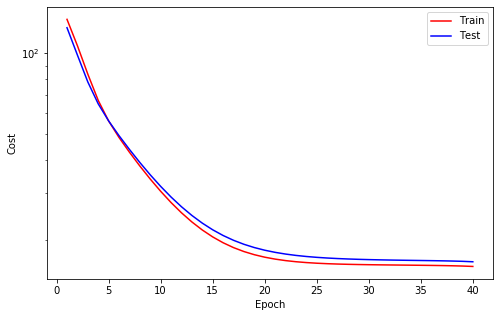



Epoch    41
Train_cost  = 15.8893 | Test_cost  = 16.5184 | 




Epoch    42
Train_cost  = 15.6954 | Test_cost  = 16.1925 | 




Epoch    43
Train_cost  = 15.2134 | Test_cost  = 15.6762 | 




Epoch    44
Train_cost  = 14.3597 | Test_cost  = 14.4621 | 




Epoch    45
Train_cost  = 13.1907 | Test_cost  = 13.3701 | 




Epoch    46
Train_cost  = 12.1827 | Test_cost  = 12.4367 | 




Epoch    47
Train_cost  = 11.5238 | Test_cost  = 11.6883 | 




Epoch    48
Train_cost  = 10.8909 | Test_cost  = 10.9951 | 




Epoch    49
Train_cost  = 10.3368 | Test_cost  = 10.3793 | 




Epoch    50
Train_cost  = 9.8686 | Test_cost  = 9.8331 | 




Epoch    51
Train_cost  = 9.4734 | Test_cost  = 9.3765 | 




Epoch    52
Train_cost  = 9.1392 | Test_cost  = 9.0003 | 




Epoch    53
Train_cost  = 8.8509 | Test_cost  = 8.6842 | 




Epoch    54
Train_cost  = 8.6058 | Test_cost  = 8.4052 | 




Epoch    55
Train_cost  = 8.3917 | Test_cost  = 8.1559 | 




Epoch    56
Train_cost  = 8.2018 | Test_cost  = 7.9356 | 




Epoch    57
Train_cost  = 8.0325 | Test_cost  = 7.7370 | 




Epoch    58
Train_cost  = 7.8832 | Test_cost  = 7.5533 | 




Epoch    59
Train_cost  = 7.7494 | Test_cost  = 7.3845 | 




Epoch    60
Train_cost  = 7.6304 | Test_cost  = 7.2330 | 


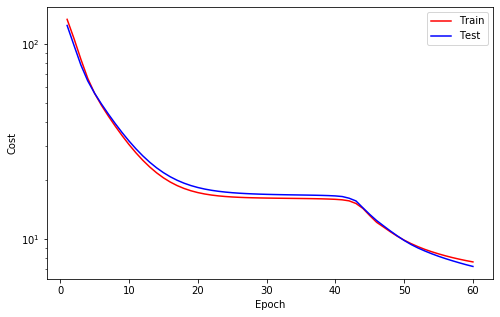



Epoch    61
Train_cost  = 7.5239 | Test_cost  = 7.0955 | 




Epoch    62
Train_cost  = 7.4285 | Test_cost  = 6.9704 | 




Epoch    63
Train_cost  = 7.3417 | Test_cost  = 6.8571 | 




Epoch    64
Train_cost  = 7.2625 | Test_cost  = 6.7545 | 




Epoch    65
Train_cost  = 7.1902 | Test_cost  = 6.6608 | 




Epoch    66
Train_cost  = 7.1234 | Test_cost  = 6.5749 | 




Epoch    67
Train_cost  = 7.0616 | Test_cost  = 6.4961 | 




Epoch    68
Train_cost  = 7.0042 | Test_cost  = 6.4230 | 




Epoch    69
Train_cost  = 6.9506 | Test_cost  = 6.3548 | 




Epoch    70
Train_cost  = 6.9003 | Test_cost  = 6.2910 | 




Epoch    71
Train_cost  = 6.8531 | Test_cost  = 6.2309 | 




Epoch    72
Train_cost  = 6.8086 | Test_cost  = 6.1741 | 




Epoch    73
Train_cost  = 6.7666 | Test_cost  = 6.1204 | 




Epoch    74
Train_cost  = 6.7268 | Test_cost  = 6.0696 | 




Epoch    75
Train_cost  = 6.6891 | Test_cost  = 6.0215 | 




Epoch    76
Train_cost  = 6.6533 | Test_cost  = 5.9759 | 




Epoch    77
Train_cost  = 6.6193 | Test_cost  = 5.9327 | 




Epoch    78
Train_cost  = 6.5871 | Test_cost  = 5.8916 | 




Epoch    79
Train_cost  = 6.5565 | Test_cost  = 5.8527 | 




Epoch    80
Train_cost  = 6.5275 | Test_cost  = 5.8158 | 


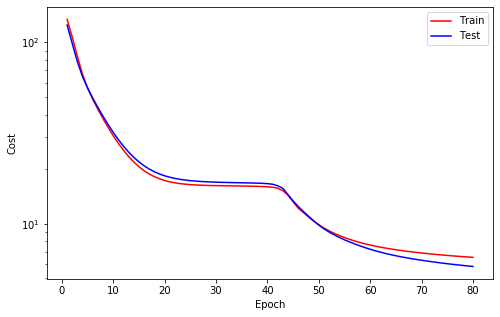



Epoch    81
Train_cost  = 6.5000 | Test_cost  = 5.7807 | 




Epoch    82
Train_cost  = 6.4739 | Test_cost  = 5.7474 | 




Epoch    83
Train_cost  = 6.4491 | Test_cost  = 5.7157 | 




Epoch    84
Train_cost  = 6.4256 | Test_cost  = 5.6858 | 




Epoch    85
Train_cost  = 6.4034 | Test_cost  = 5.6577 | 




Epoch    86
Train_cost  = 6.3822 | Test_cost  = 5.6312 | 




Epoch    87
Train_cost  = 6.3621 | Test_cost  = 5.6064 | 




Epoch    88
Train_cost  = 6.3429 | Test_cost  = 5.5830 | 




Epoch    89
Train_cost  = 6.3245 | Test_cost  = 5.5608 | 




Epoch    90
Train_cost  = 6.3070 | Test_cost  = 5.5397 | 




Epoch    91
Train_cost  = 6.2901 | Test_cost  = 5.5196 | 




Epoch    92
Train_cost  = 6.2739 | Test_cost  = 5.5003 | 




Epoch    93
Train_cost  = 6.2583 | Test_cost  = 5.4818 | 




Epoch    94
Train_cost  = 6.2433 | Test_cost  = 5.4641 | 




Epoch    95
Train_cost  = 6.2288 | Test_cost  = 5.4469 | 




Epoch    96
Train_cost  = 6.2148 | Test_cost  = 5.4304 | 




Epoch    97
Train_cost  = 6.2012 | Test_cost  = 5.4145 | 




Epoch    98
Train_cost  = 6.1882 | Test_cost  = 5.3992 | 




Epoch    99
Train_cost  = 6.1755 | Test_cost  = 5.3846 | 




Epoch   100
Train_cost  = 6.1633 | Test_cost  = 5.3705 | 


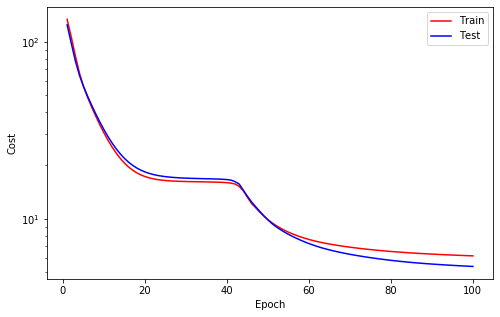



Epoch   101
Train_cost  = 6.1514 | Test_cost  = 5.3570 | 




Epoch   102
Train_cost  = 6.1398 | Test_cost  = 5.3440 | 




Epoch   103
Train_cost  = 6.1286 | Test_cost  = 5.3314 | 




Epoch   104
Train_cost  = 6.1177 | Test_cost  = 5.3193 | 




Epoch   105
Train_cost  = 6.1071 | Test_cost  = 5.3075 | 




Epoch   106
Train_cost  = 6.0968 | Test_cost  = 5.2961 | 




Epoch   107
Train_cost  = 6.0867 | Test_cost  = 5.2851 | 




Epoch   108
Train_cost  = 6.0768 | Test_cost  = 5.2745 | 




Epoch   109
Train_cost  = 6.0671 | Test_cost  = 5.2642 | 




Epoch   110
Train_cost  = 6.0576 | Test_cost  = 5.2542 | 




Epoch   111
Train_cost  = 6.0482 | Test_cost  = 5.2445 | 




Epoch   112
Train_cost  = 6.0390 | Test_cost  = 5.2351 | 




Epoch   113
Train_cost  = 6.0299 | Test_cost  = 5.2259 | 




Epoch   114
Train_cost  = 6.0208 | Test_cost  = 5.2170 | 




Epoch   115
Train_cost  = 6.0120 | Test_cost  = 5.2083 | 




Epoch   116
Train_cost  = 6.0032 | Test_cost  = 5.1997 | 




Epoch   117
Train_cost  = 5.9945 | Test_cost  = 5.1915 | 




Epoch   118
Train_cost  = 5.9860 | Test_cost  = 5.1834 | 




Epoch   119
Train_cost  = 5.9776 | Test_cost  = 5.1755 | 




Epoch   120
Train_cost  = 5.9692 | Test_cost  = 5.1678 | 


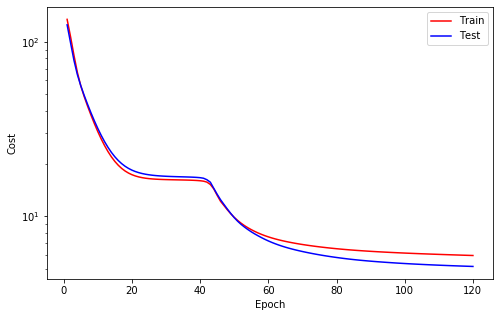



Epoch   121
Train_cost  = 5.9610 | Test_cost  = 5.1603 | 




Epoch   122
Train_cost  = 5.9529 | Test_cost  = 5.1529 | 




Epoch   123
Train_cost  = 5.9449 | Test_cost  = 5.1457 | 




Epoch   124
Train_cost  = 5.9369 | Test_cost  = 5.1386 | 




Epoch   125
Train_cost  = 5.9291 | Test_cost  = 5.1317 | 




Epoch   126
Train_cost  = 5.9214 | Test_cost  = 5.1248 | 




Epoch   127
Train_cost  = 5.9137 | Test_cost  = 5.1181 | 




Epoch   128
Train_cost  = 5.9062 | Test_cost  = 5.1115 | 




Epoch   129
Train_cost  = 5.8988 | Test_cost  = 5.1051 | 




Epoch   130
Train_cost  = 5.8915 | Test_cost  = 5.0989 | 




Epoch   131
Train_cost  = 5.8843 | Test_cost  = 5.0928 | 




Epoch   132
Train_cost  = 5.8772 | Test_cost  = 5.0868 | 




Epoch   133
Train_cost  = 5.8702 | Test_cost  = 5.0811 | 




Epoch   134
Train_cost  = 5.8633 | Test_cost  = 5.0755 | 




Epoch   135
Train_cost  = 5.8565 | Test_cost  = 5.0700 | 




Epoch   136
Train_cost  = 5.8498 | Test_cost  = 5.0647 | 




Epoch   137
Train_cost  = 5.8431 | Test_cost  = 5.0596 | 




Epoch   138
Train_cost  = 5.8365 | Test_cost  = 5.0546 | 




Epoch   139
Train_cost  = 5.8300 | Test_cost  = 5.0497 | 




Epoch   140
Train_cost  = 5.8236 | Test_cost  = 5.0450 | 


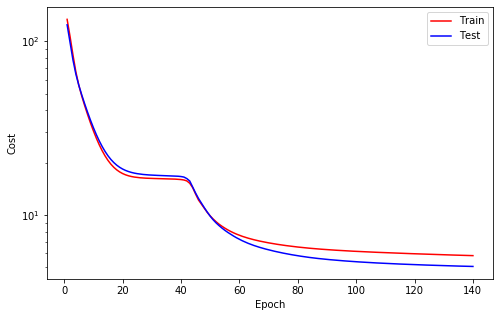



Epoch   141
Train_cost  = 5.8173 | Test_cost  = 5.0404 | 




Epoch   142
Train_cost  = 5.8110 | Test_cost  = 5.0360 | 




Epoch   143
Train_cost  = 5.8048 | Test_cost  = 5.0317 | 




Epoch   144
Train_cost  = 5.7987 | Test_cost  = 5.0276 | 




Epoch   145
Train_cost  = 5.7926 | Test_cost  = 5.0236 | 




Epoch   146
Train_cost  = 5.7865 | Test_cost  = 5.0197 | 




Epoch   147
Train_cost  = 5.7805 | Test_cost  = 5.0160 | 




Epoch   148
Train_cost  = 5.7745 | Test_cost  = 5.0124 | 




Epoch   149
Train_cost  = 5.7686 | Test_cost  = 5.0089 | 




Epoch   150
Train_cost  = 5.7627 | Test_cost  = 5.0055 | 




Epoch   151
Train_cost  = 5.7568 | Test_cost  = 5.0022 | 




Epoch   152
Train_cost  = 5.7509 | Test_cost  = 4.9990 | 




Epoch   153
Train_cost  = 5.7450 | Test_cost  = 4.9959 | 




Epoch   154
Train_cost  = 5.7391 | Test_cost  = 4.9929 | 




Epoch   155
Train_cost  = 5.7333 | Test_cost  = 4.9900 | 




Epoch   156
Train_cost  = 5.7274 | Test_cost  = 4.9871 | 




Epoch   157
Train_cost  = 5.7216 | Test_cost  = 4.9844 | 




Epoch   158
Train_cost  = 5.7159 | Test_cost  = 4.9818 | 




Epoch   159
Train_cost  = 5.7101 | Test_cost  = 4.9793 | 




Epoch   160
Train_cost  = 5.7044 | Test_cost  = 4.9769 | 


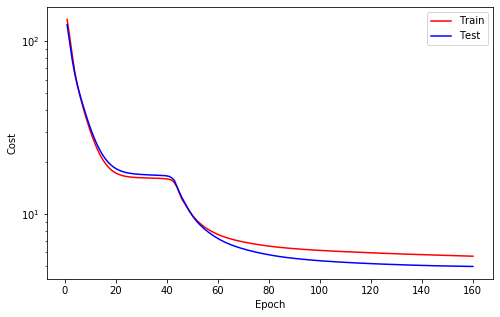



Epoch   161
Train_cost  = 5.6988 | Test_cost  = 4.9747 | 




Epoch   162
Train_cost  = 5.6932 | Test_cost  = 4.9727 | 




Epoch   163
Train_cost  = 5.6877 | Test_cost  = 4.9708 | 




Epoch   164
Train_cost  = 5.6823 | Test_cost  = 4.9691 | 




Epoch   165
Train_cost  = 5.6769 | Test_cost  = 4.9675 | 




Epoch   166
Train_cost  = 5.6715 | Test_cost  = 4.9661 | 




Epoch   167
Train_cost  = 5.6662 | Test_cost  = 4.9649 | 




Epoch   168
Train_cost  = 5.6610 | Test_cost  = 4.9639 | 




Epoch   169
Train_cost  = 5.6558 | Test_cost  = 4.9630 | 




Epoch   170
Train_cost  = 5.6507 | Test_cost  = 4.9623 | 




Epoch   171
Train_cost  = 5.6455 | Test_cost  = 4.9618 | 




Epoch   172
Train_cost  = 5.6405 | Test_cost  = 4.9614 | 




Epoch   173
Train_cost  = 5.6354 | Test_cost  = 4.9612 | 




Epoch   174
Train_cost  = 5.6303 | Test_cost  = 4.9612 | 




Epoch   175
Train_cost  = 5.6253 | Test_cost  = 4.9613 | 
==> EarlyStop patience =  1 | Best test_cost: 4.9612




Epoch   176
Train_cost  = 5.6202 | Test_cost  = 4.9615 | 
==> EarlyStop patience =  2 | Best test_cost: 4.9612




Epoch   177
Train_cost  = 5.6151 | Test_cost  = 4.9619 | 
==> EarlyStop patience =  3 | Best test_cost: 4.9612




Epoch   178
Train_cost  = 5.6100 | Test_cost  = 4.9623 | 
==> EarlyStop patience =  4 | Best test_cost: 4.9612




Epoch   179
Train_cost  = 5.6049 | Test_cost  = 4.9630 | 
==> EarlyStop patience =  5 | Best test_cost: 4.9612
==> Execute Early Stopping at epoch: 179 | Best test_cost: 4.9612
==> Best model is saved at model/multivar


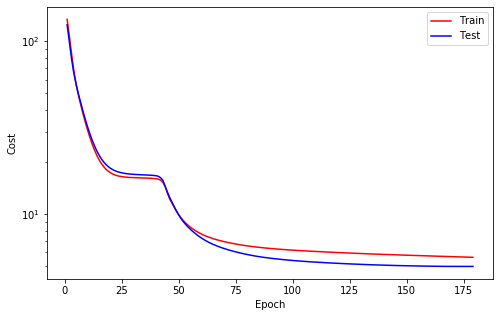

In [14]:
# training
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging 
    callback.log(train_cost, test_cost)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [17]:
# import package
from utils import data4pred, pred4pred

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

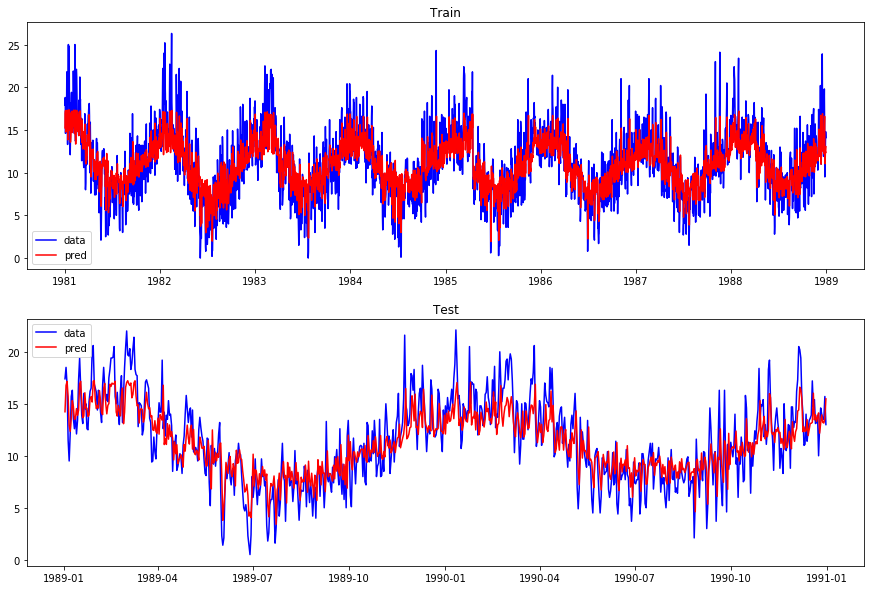

In [19]:
# Data for pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

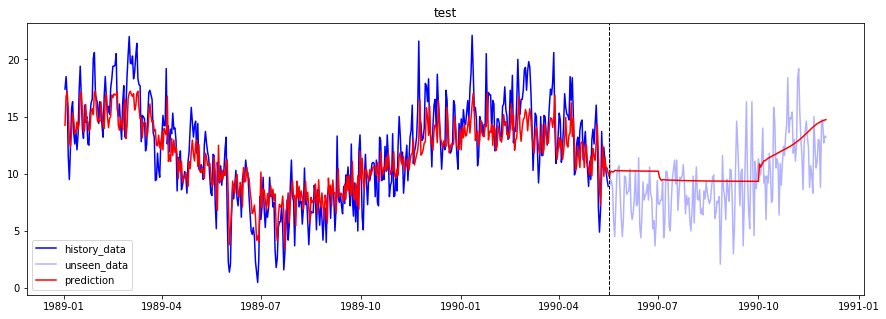

In [21]:
# Pred for Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")